In [1]:
# install.packages("rpart.plot")

library(corrplot)
library(repr)
library(dplyr)
library(ggplot2)
library(GGally)
library(rpart)
library(ggparty)
library(caret)
library(rpart.plot)
library(randomForest)

Warning message:
"package 'corrplot' was built under R version 4.3.2"
corrplot 0.92 loaded

Warning message:
"package 'repr' was built under R version 4.3.2"
Warning message:
"package 'dplyr' was built under R version 4.3.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.3.2"
Warning message:
"package 'GGally' was built under R version 4.3.2"
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
"package 'rpart' was built under R version 4.3.2"
Warning message:
"package 'ggparty' was built under R version 4.3.2"
Loading required package: partykit

Warning message:
"package 'partykit' was built under R version 4.3.2"
Loading required package: grid

Loading required package: libcoin

Warning message:
"package 'libcoin' was built u

In [2]:
pokemon = read.csv('pokemon.csv')

str(pokemon)

'data.frame':	801 obs. of  41 variables:
 $ abilities        : chr  "['Overgrow', 'Chlorophyll']" "['Overgrow', 'Chlorophyll']" "['Overgrow', 'Chlorophyll']" "['Blaze', 'Solar Power']" ...
 $ against_bug      : num  1 1 1 0.5 0.5 0.25 1 1 1 1 ...
 $ against_dark     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ against_dragon   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ against_electric : num  0.5 0.5 0.5 1 1 2 2 2 2 1 ...
 $ against_fairy    : num  0.5 0.5 0.5 0.5 0.5 0.5 1 1 1 1 ...
 $ against_fight    : num  0.5 0.5 0.5 1 1 0.5 1 1 1 0.5 ...
 $ against_fire     : num  2 2 2 0.5 0.5 0.5 0.5 0.5 0.5 2 ...
 $ against_flying   : num  2 2 2 1 1 1 1 1 1 2 ...
 $ against_ghost    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ against_grass    : num  0.25 0.25 0.25 0.5 0.5 0.25 2 2 2 0.5 ...
 $ against_ground   : num  1 1 1 2 2 0 1 1 1 0.5 ...
 $ against_ice      : num  2 2 2 0.5 0.5 1 0.5 0.5 0.5 1 ...
 $ against_normal   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ against_poison   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ against_psychic  

In [3]:
#check the unique values of these six character variables
print(length(unique(pokemon$abilities)))
print(length(unique(pokemon$capture_rate)))
print(length(unique(pokemon$classfication)))
print(length(unique(pokemon$japanese_name)))
print(length(unique(pokemon$name)))
print(length(unique(pokemon$type2)))


[1] 482
[1] 34
[1] 588
[1] 801
[1] 801
[1] 19


In [4]:
# convert capture_rate into numerical type 
pokemon$capture_rate <- as.numeric(pokemon$capture_rate)
#drop some useless columns  
pokemon = subset(pokemon, select = -c( japanese_name, name, pokedex_number, type2, abilities , classfication)) 

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"



   water   normal    grass      bug  psychic     fire     rock electric 
     114      105       78       72       53       52       45       39 
  ground   poison     dark fighting   dragon    ghost    steel      ice 
      32       32       29       28       27       27       24       23 
   fairy   flying 
      18        3 

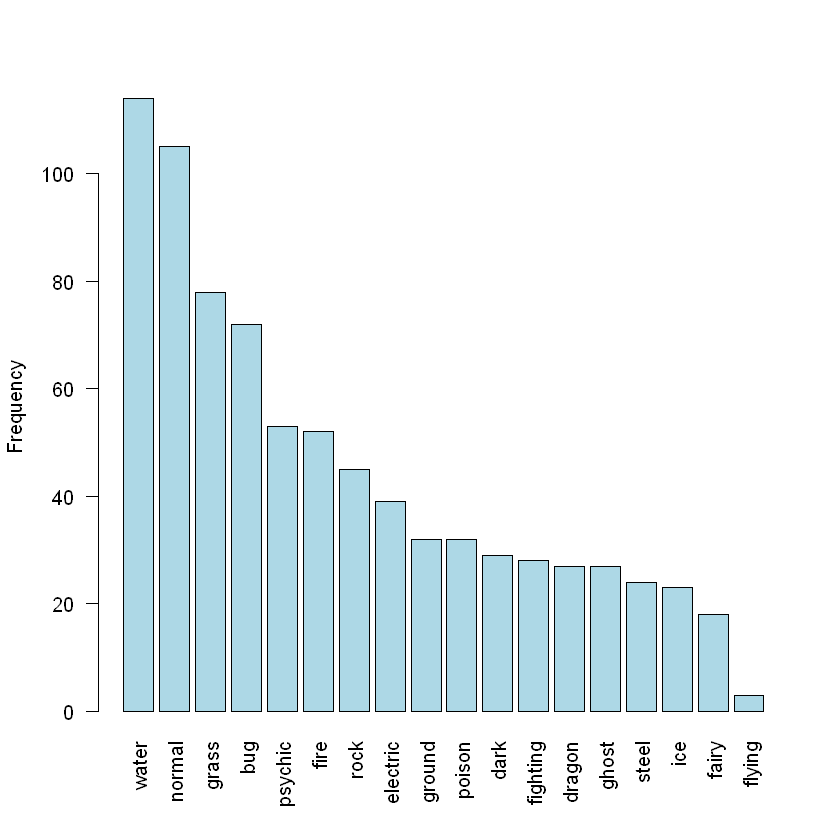

In [5]:
# check the frequency of target variable, type1 
pokemon_unique_type1 <- table(pokemon$type1)
type1_unique_values = sort(pokemon_unique_type1, decreasing = TRUE)
type1_unique_values

# Plot the distribution
barplot(type1_unique_values, 
        ylab = "Frequency",
        col = "lightblue",
        las = 2)  

In [6]:
### check na data
colSums(is.na(pokemon))

against_bug      against_dark    against_dragon  against_electric 
                0                 0                 0                 0 
    against_fairy     against_fight      against_fire    against_flying 
                0                 0                 0                 0 
    against_ghost     against_grass    against_ground       against_ice 
                0                 0                 0                 0 
   against_normal    against_poison   against_psychic      against_rock 
                0                 0                 0                 0 
    against_steel     against_water            attack    base_egg_steps 
                0                 0                 0                 0 
   base_happiness        base_total      capture_rate           defense 
                0                 0                 1                 0 
experience_growth          height_m                hp   percentage_male 
                0                20                 0                98 
        sp_attack        sp_defense             speed             type1 
                0                 0                 0                 0 
        weight_kg        generation      is_legendary 
               20                 0                 0

In [7]:
#####fill in missing value, treat missing values as a seprate group
pokemon_filled <- pokemon %>%
  mutate(weight_kg = ifelse(is.na(weight_kg), 999, weight_kg),
         percentage_male = ifelse(is.na(percentage_male), 999, weight_kg),
         height_m = ifelse(is.na(height_m), 999, weight_kg),
         capture_rate = ifelse(is.na(capture_rate), 999, capture_rate),
        ) 

In [13]:
# split data into training and testing data set
set.seed(42)

train_proportion = 0.75  #75%, that's what caret do in default 
ind = sample(seq_len(nrow(pokemon_filled)), size = round(train_proportion * nrow(pokemon)))

training = pokemon_filled[ind,]  
testing = pokemon_filled[-ind,]

In [14]:
dim(testing)

[1] 200  35

# model 1: CART

In [16]:
start_time = Sys.time()

cart_model = rpart(type1 ~  .,
                          data = training, 
                          method = "class",
                          control = rpart.control(cp = 0.02),
                          xval = nrow(training), 
                          )

# Print the cross-validation results
printcp(cart_model)
# plot(as.party(cart_model))

end_time = Sys.time()

# # Calculate elapsed time
time_cart = end_time - start_time
time_cart


Classification tree:
rpart(formula = type1 ~ ., data = training, method = "class", 
    control = rpart.control(cp = 0.02), xval = nrow(training))

Variables actually used in tree construction:
 [1] against_dragon  against_fairy   against_fire    against_flying 
 [5] against_ghost   against_grass   against_poison  against_psychic
 [9] against_steel   against_water  

Root node error: 517/601 = 0.86023

n= 601 

         CP nsplit rel error  xerror     xstd
1  0.156673      0   1.00000 1.03095 0.015021
2  0.091876      1   0.84333 0.84333 0.021162
3  0.067698      3   0.65957 0.69052 0.023286
4  0.061896      4   0.59188 0.61896 0.023659
5  0.058027      5   0.52998 0.58221 0.023709
6  0.042553      6   0.47195 0.49903 0.023471
7  0.040619      7   0.42940 0.45841 0.023174
8  0.034816      8   0.38878 0.43133 0.022907
9  0.032882      9   0.35397 0.38491 0.022316
10 0.027079     10   0.32108 0.33462 0.021469
11 0.025145     11   0.29400 0.30754 0.020916
12 0.023211     15   0.19342 0.2

Time difference of 0.06370592 secs

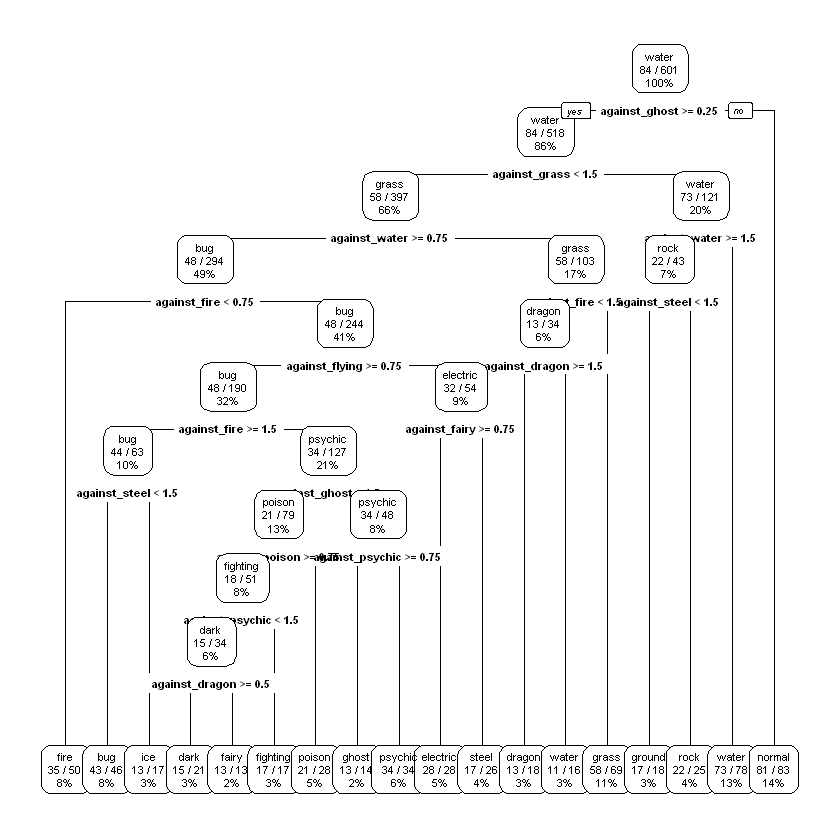

In [17]:
rpart.plot(cart_model, fallen.leaves = TRUE, extra = 102, box.palette = 0,  tweak = 1.5)

In [18]:
#predict on testing dataset
pred_testing = testing %>% mutate(pred_type1 = predict(cart_model, newdata = testing, type = "class"))

In [19]:
#compare the real and predict type1 in testing dataset
pred_testing$pred_type1 = as.character(pred_testing$pred_type1)

comparison = pred_testing %>%
  mutate(correct_prediction = ifelse(type1 == pred_type1, "Correct", "Incorrect"))

In [21]:
# Calculate the numerator
correct_predictions <- sum(pred_testing$type1 == pred_testing$pred_type1)
wrong_predictions <- sum(pred_testing$type1 != pred_testing$pred_type1)

# Calculate the accuracy rate
accuracy_rate <- correct_predictions / (correct_predictions + wrong_predictions)

# Output the numerator, denominator, and accuracy rate
cat("Correct Predictions:", correct_predictions, "\n")
cat("Wrong Predictions:", wrong_predictions, "\n")
cat("Accuracy Rate:", accuracy_rate, "\n")

#accuracy on testing data 
accuracy_CART = mean(pred_testing$type1 == pred_testing$pred_type1)
accuracy_CART

Correct Predictions: 165 
Wrong Predictions: 35 
Accuracy Rate: 0.825 


[1] 0.825

# model 2: RF model 

In [24]:
# Convert categorical variables to factors
categorical_vars = sapply(training, is.character)
training[categorical_vars] = lapply(training[categorical_vars], as.factor)

In [26]:
set.seed(42)

start_time = Sys.time()
rf = randomForest(type1 ~ ., data = training, mtry = 4)

print(rf)

end_time = Sys.time()

time_rf = end_time - start_time
time_rf


Call:
 randomForest(formula = type1 ~ ., data = training, mtry = 4) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 7.99%
Confusion matrix:
         bug dark dragon electric fairy fighting fire flying ghost grass ground
bug       51    0      0        0     0        0    0      0     0     0      0
dark       0   21      0        0     0        0    1      0     0     0      0
dragon     0    0     15        0     0        0    1      0     0     0      1
electric   1    0      0       31     1        0    0      0     0     0      0
fairy      0    0      0        0    13        0    0      0     0     0      0
fighting   0    1      0        0     0       19    0      0     0     0      0
fire       0    0      0        0     0        0   36      0     0     0      0
flying     0    0      0        1     0        0    0      0     0     0      0
ghost      0 

Time difference of 0.9594018 secs

In [31]:
# predict on testing data 
pred_testing_RF = testing %>% mutate(pred_type1 = predict(rf, newdata = testing))

In [32]:
#compare the real and predict type1 in testing dataset
pred_testing_RF$pred_type1 = as.character(pred_testing_RF$pred_type1)

comparison_RF = pred_testing_RF %>%
  mutate(correct_prediction = ifelse(type1 == pred_type1, "Correct", "Incorrect"))

In [33]:
#accuracy on testing data 
accuracy_RF = mean(pred_testing_RF$type1 == pred_testing_RF$pred_type1)
accuracy_RF

[1] 0.895

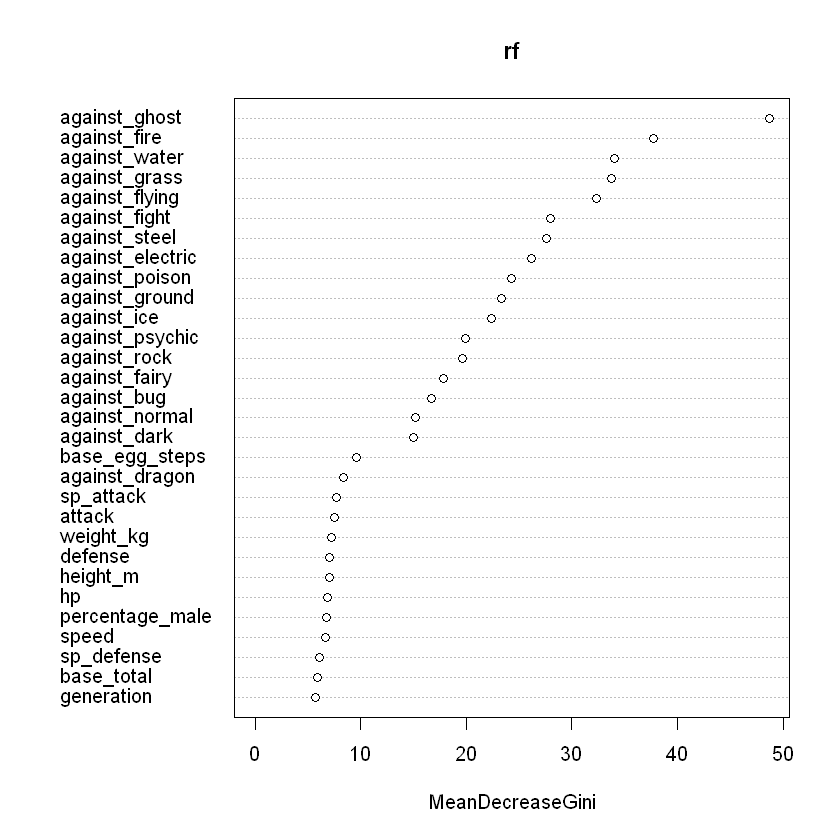

In [34]:
# Plot variable importance
varImpPlot(rf)

In [35]:
var_importance <- importance(rf)
var_importance_df <- as.data.frame(var_importance)
variable_names <- rownames(var_importance_df)
mean_decrease_gini <- var_importance_df$MeanDecreaseGini

# Create a new data frame with two columns
result_df <- data.frame(Variable = variable_names, MeanDecreaseGini = mean_decrease_gini)

# # Step 3: Sort the data frame by MeanDecreaseGini in descending order
result_df_sort <- result_df[order(-var_importance_df$MeanDecreaseGini), ]
result_df_sort

# # Select top 5 important variables
top_5_variables <- result_df_sort$Variable[1:5]
top_5_variables
# # Print the top 5 important variables
# print(result_df)


,Variable,MeanDecreaseGini
,<chr>,<dbl>
9,against_ghost,48.6672010
7,against_fire,37.7309111
18,against_water,34.0399842
10,against_grass,33.7582049
8,against_flying,32.3701814
6,against_fight,27.9277151
17,against_steel,27.5587599
4,against_electric,26.1283343
14,against_poison,24.3039734


[1] "against_ghost"  "against_fire"   "against_water"  "against_grass" 
[5] "against_flying"